<a href="https://colab.research.google.com/github/Buchunwang/UK-CLI/blob/main/UK_CLI_kalman_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Algorithm of Kalman filter part for our study of UK composite leading indicator completely follows Kim and Nelson (1998). 

---


Step 1: run kalman filter

---


Step 2: take $Δ c_{t+1}$ as observations and add it to the information set.





First, we import detrended data of CLI and its component variables from 1986 to 2021. Data has been uploaded to Github.

In [1]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kalpre.csv'
print('From URL:', url)
kalpre = pd.read_csv(url, header=None, encoding='utf-8', skiprows=1)

From URL: https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kalpre.csv


standardize the data

In [2]:
from sklearn.preprocessing import StandardScaler
scale= StandardScaler()
kalpre = scale.fit_transform(kalpre) 



---


**Modeling of the algorithm**

---

1.
\begin{equation}
\Delta Y_{it}=\lambda_i(L)\Delta C_t+D_i+e_{it} \ \ \ i=1,2,3,4,5 \ \ \ t=1,2… T
\end{equation}
$Y_{it}$ are component series above except passenger car registrations,$C_t$ is the growth rate of CLI, 
$\lambda _i(L)=\lambda _i $ here for simplicity.






2.

\begin{equation}
\Psi_i(L)e_{it}=\epsilon_{it},  \ \ \ \epsilon_{it}\sim iid N(0,\sigma_i^2)	  
\end{equation}
where $\Psi_i(L)=1-\psi_{i1}L-\psi_{i2}L^2$, $L$ is the lag operator

3.
\begin{equation}
\Phi(L)(\Delta C_t-\mu_{s_t}-\delta
)=v_t\ \ \ \ \ \ \ \ \ \ v_t\sim iid N(0,σ^2_{vt})	
\end{equation}
where $\Phi(L)=1-\phi_1L-\phi_2L^2$. $\mu_{s_t}-\delta$ is the mean growth rate of $\Delta C_t$, $\mu_{s_t}$ is the regime-switching component.



4.

\begin{equation}
	\mu_{s_t}=\mu_0+\mu_1S_t
\end{equation}
where $S_t=\{\begin{matrix}
		0,1
	\end{matrix}\}$
 and $\mu_1<0$. 
The regime-switching happens at the mean value of $\Delta C_t$.





---
Before we run the kalman filter, all parameters including $λ_i(L), Ψ_i(L), Φ(L), Φ(L)\cdot μ_{st}, σ_i, σ_{vt}, D_i, δ$ need to be calculated.

---
Now we start the process of calculating parameters


First, we make a regression based on equation 1. We can then obtain intercept $D_i$, coefficients $λ _i$ and resudual series $e_{it}$.
Based on equation 2 and generated residual series $e_{it}$, we can also get the corresponding $σ_i$ and coefficients $\psi_{i1}$ and $\psi_{i2}$.


In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression

N = 421 #length of input
Y = np.transpose(kalpre[:,3:9])#Y_{1t} to Y_{5t}
#set empty matrices to save value of parameters later on
lamda = np.zeros((1, 5))
D = np.zeros((1, 5))
var_e = np.zeros((1, 5)) #variance of e_it
var_ep = np.zeros((1, 5))#variance of epsilon_it
xe = np.zeros((N - 2, 2))#for calculating equation 2 ,xe=[e_it-1,e_it-2]
psi = np.zeros((5, 2))

for i in range(5):
    reg = LinearRegression(fit_intercept=True)
    reg.fit(kalpre[:, 0:1], Y[i, :])#regression for yi,i=1,2,3,4,5
    lamda[0, i] = reg.coef_[0]
    D[0, i] = reg.intercept_
    r = Y[i, :] - reg.predict(kalpre[:, 0:1])
    var_e[0, i] = np.var(r)
    
    xe[:, 0] = r[1:N-1]
    xe[:, 1] = r[0:N-2]
    reg2 = LinearRegression(fit_intercept=False)
    reg2.fit(xe, r[2:N])
    var_ep[0, i] = np.var(reg2.predict(xe) - r[2:N])#regression for e_it,i=1,2,3,4,5
    psi[i, 0] = reg2.coef_[0]
    psi[i, 1] = reg2.coef_[1]


From above, we have obtained $D_i, Ψ_i(L), σ_i, λ_i$, now we come to the process of calculating $Φ(L), Φ(L)\cdot μ_{st}, σ_{vt}, δ$ based on equation 3.

In [4]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
# Calculate delta_y, delta_y_t-1, and delta_y_t-2
# Yit-E(Y), remove the mean value
y = np.zeros((5, N))
y1lag = np.zeros((5, N))
y2lag = np.zeros((5, N))
for i in range(5):
    y[i-1, :] = kalpre[:, i + 2] - np.mean(kalpre[:, i + 2])
    y1lag[i-1, :] = kalpre[:, i + 7] - np.mean(kalpre[:, i + 7])
    y2lag[i-1, :] = kalpre[:, i + 12] - np.mean(kalpre[:, i + 12])

# Calculate phi
# Calculate phi based on equation 3 
regressor = kalpre[:, 1:3] - np.mean(kalpre[:, 1:3], axis=0)  # 2nd and 3rd columns of kalpre
response = kalpre[:, 0] - np.mean(kalpre[:, 0])  # 1st column of kalpre
# delta is the long-term mean value of delta C_t (delta=E(delta C_t)) and mu_st is the state-dependent element mean value
# E(mu_st)=0 according to Kim and Nelson (1998)
regressor = sm.add_constant(regressor)
model = sm.OLS(response, regressor)
result = model.fit()
phi = result.params
var_vt = np.var(result.resid) #we can generate the variance of vt from the residual series
mu_st = kalpre[:, 0] - phi[0] * kalpre[:, 1] - phi[1] * kalpre[:, 2] - np.mean(kalpre[:, 0]) - \
        norm.rvs(loc=0, scale=np.sqrt(var_vt), size=N,) # Phi(L)*mu_st=PHI(L)(C_t-delta)-vt, vt~iid N(0,sigma_vt^2)
mu_st = mu_st.reshape((1, -1))


With all parameters ready, we can then form matrices of the state-space model for Kalman filter
\begin{equation}
	\Delta y^*_t=H^*\zeta_t+\epsilon_t
\end{equation}
\begin{equation}
	\zeta_t=\tilde M^*_{s_t}+F^*\zeta_{t-1}+u^*_t
\end{equation}
which can be expanded as
\begin{equation}
\begin{bmatrix}
	\Delta y^*_{1t}\\ \Delta y^*_{2t}\\ \Delta y^*_{3t}\\ \Delta y^*_{4t}\\ \Delta y^*_{5t}
\end{bmatrix}
=
\begin{bmatrix}
	\lambda_1&\ \  -\lambda_i\psi_{11}&\ \ -\lambda\psi_{12}\\
	\lambda_2&\ \ -\lambda_i\psi_{21}&\ \ -\lambda\psi_{22}\\
	\lambda_3&\ \ -\lambda_i\psi_{31}&\ \ -\lambda\psi_{32}\\
	\lambda_4&\ \ -\lambda_i\psi_{41}&\ \ -\lambda\psi_{42}\\
	\lambda_5&\ \ -\lambda_i\psi_{51}&\ \ -\lambda\psi_{52}\\
\end{bmatrix}
\begin{bmatrix}
	\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2} 
\end{bmatrix}
+
\begin{bmatrix}
	\epsilon_{1t}\\
	\epsilon_{2t}\\
	\epsilon_{3t}\\
	\epsilon_{4t}\\
	\epsilon_{5t}\\
\end{bmatrix}		
\end{equation}
\begin{equation}
	\begin{bmatrix}
\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}	
	\end{bmatrix}
	=
	\begin{bmatrix}
		\Phi(L)\mu_{s_t}\\
		\Phi(L)\mu_{s_{t-1}}\\
		0
	\end{bmatrix}
	+\begin{bmatrix}
		\phi_1&\phi_2 & 0\\
		0&\phi_1&\phi_2\\
		0&1&0
	\end{bmatrix}
	\begin{bmatrix}
	\Delta c_{t-1}\\ \Delta c_{t-2} \\ \Delta c_{t-3}	
	\end{bmatrix}
	+
	\begin{bmatrix}
		v_t\\ v_{t-1} \\ 0
	\end{bmatrix}
\end{equation}


In [5]:
# Construct H and A
H = np.array([[lamda[0,0], -lamda[0,0]*psi[0, 0], -lamda[0,0]*psi[0, 1]],
              [lamda[0,1], -lamda[0,1]*psi[1, 0], -lamda[0,1]*psi[1, 1]],
              [lamda[0,2], -lamda[0,2]*psi[2, 0], -lamda[0,2]*psi[2, 1]],
              [lamda[0,3], -lamda[0,3]*psi[3, 0], -lamda[0,3]*psi[3, 1]],
              [lamda[0,4], -lamda[0,4]*psi[4, 0], -lamda[0,4]*psi[4, 1]]])
A = np.array([[phi[0], phi[1], 0],
              [0, phi[0], phi[1]],
              [0, 1, 0]])

# Construct delta_y*
ystar = y.T - np.multiply(psi[:, 0].T, y1lag[0:5, :].T)- np.multiply(psi[:, 1].T,y2lag[0:5, :].T)
ystar=ystar.T


# Initialize variables
Q = np.array([[var_vt, 0, 0],
[0, var_vt, 0],
[0, 0, 0]])#process noise, variance matrix of [vt;vt-1;0]
R = np.array([[var_ep[0,0], 0, 0, 0, 0],
             [0, var_ep[0,1], 0, 0, 0],
             [0, 0, var_ep[0,2], 0, 0],
             [0, 0, 0, var_ep[0,3], 0],
             [0, 0, 0, 0, var_ep[0,4]]])#observation noise, variance matrix of [epsilon 1,epsilon 2,epsilon 3,epsilon 4,epsilon 5]
P = 0.1 * np.eye(3)# initial setting of variance matrix of xi_t
z = np.ones((5, N))
k = 0
true5D = ystar
x = np.zeros((3, N))#empty matrix to save mean value of xi_t
vct = np.zeros((3, N))#empty matrix to save variance of xi_t


Now everything is ready. Let's run the Kalman Filter

---

---




The function of Kalman filter is to estimate mean and variance of $\zeta_t$.  

Algorithm of Kalman filter is show as follows

1.
\begin{equation}
 \zeta_{k|k-1}=F^*\zeta_{k-1|k-1}
 \end{equation} 
 Equation 1 is the process of **predicting** mean value of $\zeta_t $ from $\zeta_{t-1}$.  $\  \zeta_{t|t-1}=E[\zeta_t|t-1]=E[F*\zeta_{t-1}+\phi(L)\mu_{st}+v_t|t-1]=F*\zeta_{t-1}$ as $\mu_{st}$ is imposed mean zero in the setting according to Kim and Nelson (1998) and $v_t$ is iid noise of time t. For the first input $t=1$, we assume $\zeta_{1|1}=0$.
   
2.
 \begin{equation}
 P_{k|k-1}=F^*P_{k-1|k-1}F^{*^T}+Q
 \end{equation}
 Equation 2 is the process of **predicting** variance of $\zeta_t $ from $\zeta_{t-1}$. $Q$ is the variance matrix of process noise $[v_t,\ v_{t-1},\ 0]'$.  

 3.
\begin{equation}
	K(k)= P_{k|k-1}H^{*^T}[H^*P_{k|k-1}H^{*^T}+R]^{-1}      
\end{equation}
Equation 3 is the process of **filtering** or upgrading. Through this equation we can obtain the value of Kalman gain $K$. Kalman gain would stablize after a few iterations (which is called as steady-state Kalman gain). This is caused by the stablized variance matrix $P$ after a few iterations.
  

4.
\begin{equation}
 \zeta_{k|k}= \zeta_{k|k-1}+K(k)([\Delta y^*_k-H^*\zeta_{k|k-1}]
\end{equation}
Equation 4 is the process of **filtering** mean value of $\zeta_t$ by adding the filtered error term at time t.
  

5.
\begin{equation}
	P_{k|k}=[I-K(k)H^*]P_{k|k-1}
\end{equation}
where $I$ is identity matrix.  
Equation 5 is the process of **filtering** variance of $\zeta_t$. $P$ would stablized with the stablization of Kalman gain.
  

---


We iteratively run the algorithm from equation 1 to 5 from $t=1$ to $t=N$ and we can get the filtered mean value and variance for $t=1\dots N$ from each iteration.

In [6]:
k = 0
for t in range(N-1):
    k += 1
    x[:, k] = np.dot(A, x[:, k-1])  # + mut[:, k]  # Kalman equation 1
    P = np.dot(A, np.dot(P, A.T)) + Q  # Kalman equation 2
    K = np.dot(P, np.dot(H.T, np.linalg.inv(np.dot(H, np.dot(P, H.T)) + R)))  # Kalman equation 3
    z[:, k] = [true5D[0, k], true5D[1, k], true5D[2, k], true5D[3, k], true5D[4, k]]   
    x[:, k] = x[:, k] + np.dot(K, (z[:, k] - np.dot(H, x[:, k])))  # Kalman equation 4
    P = np.dot((np.eye(3) - np.dot(K, H)), P)  # Kalman equation 5
    vct[0, k] = P[0, 0]  # save variance of delta_ct
    vct[1, k] = P[1, 1]
    vct[2, k] = P[2, 2]

Step2: Take $\Delta\ c_{t+1}$ as observation and run a backward iteration to improve the effect of estimation.

---

We take $\Delta c_{t+1}$ as extra observation and add  it to information set to lower the variance based on the following equation:
\begin{equation}
	p(\tilde{\zeta}_T|\Delta\tilde{y}^*_T)=p(\zeta_T|\Delta\tilde{y}^*_T)\mathop{\Pi}\limits^{T-1}_{t=1}p(\zeta _t|\Delta\tilde{y}^*_t,\zeta _{t+1})
\end{equation}
where joint distribution $\tilde{\zeta}_T=[\begin{matrix}
	\zeta_1 &\zeta_2& \cdots &\zeta_T
\end{matrix}]$' and $\tilde{y}_T=[\begin{matrix}
	y_1 &y_2& \cdots &y_T
\end{matrix}]$'.
\\ From last step, $\zeta _{t|t}$ and $V_{t|t}$ is obtained and we generated $\Delta c_T$. In this step, $\Delta c_t$ for $t=1,2,\cdots T-1$ is what we are going to generate. We follow \citet{kim} and chapter 13 of \citet{ham2}, the updating equations of adding $\Delta c_{t+1}$ into information set are:  

\begin{equation}
	\zeta_{t|t,\Delta c_{t+1}}=\zeta_{t|t}+V_{t|t}F^*(1)\eta_t/R_t
\end{equation}  

\begin{equation}
	V_{t|t,\Delta c_{t+1}}=V_{t|t}-V_{t|t}F^*(1)F^*(1)'V_{t|t}'/R_t
\end{equation}  

where $\eta_t=\Delta c_{t+1}-\Phi(L)\mu_{t+1}-F^*(1)\zeta_{t|t}$ and $E_t=F^*(1)V_{t|t}F^*(1)'+var[u^*_{t+1}(1)]$. $F^*(1)$ and $u^*_{t+1}(1)$ are first row of $F^*$ and $u^*_{t+1}$.
  
  With the new mean $\zeta_{t|t,\Delta c_{t+1}}$ and variance $V_{t|t,\Delta c_{t+1}}$ conditional on $\Delta c_{t+1}$, we can generate $\Delta c_t$ for $t=1,2,\cdots T-1$, we have also got $\Delta c_T$ from last step. In the end, we get $\Delta c_t$ for $t=1,2,\cdots T$

In [7]:
from numpy.random import normal

c = normal(x[0, N-1], np.sqrt(vct[0, N-1]))  # generate delta_c_T
xi = np.zeros((1, N))
V = np.zeros((1, N))
for i in range(N-1):  # this loop is just for xi_t and V_t conditional on delta_ct+1 for t=1,2,...,T-1
    eta = c - mu_st[0,N-i-1] - phi[0]*x[0, N-i-2] - phi[1]*x[1, N-i-2]  # value of eta_t two lag in my model, that's why I have term -phi(2)*x(2,N-i)
    Rt = np.sum(A[0]*vct[:, N-i-1]*A[0])+var_vt
    xi[0, N-i-1] = x[0, N-i-2] + phi[0]*vct[0, N-i-1]*eta/Rt
    # we only use first row of the mean and variance vector
    # so I calculated the first element of each mean & variance directly
    V[0, N-i-1] = vct[0, N-i-1] - phi[0]**2 * vct[0,N-i-1]**2 / Rt
    c = normal(xi[0, N-i-1], np.sqrt(V[0, N-i-1]))
V[0, N-1] = vct[0, N-1]# V_T didn't get upgraded, it's still from step 1
xi[0, N-1] = x[0, N-1]# xi_T didn't get upgraded, it's still from step 1


With new mean and variance of $Δ\ c_t$, distribution of $Δ\ c_t$ for $t=1\dots T$ are all known. We can then generate the value of $Δ\ c_t$ by Monte Carlo. Then we can gnerate value of estimate composite leading indicator $C_t$.  
$C_t=C_{t-1}+Δ \ c_t+δ$.

In [8]:
import numpy as np
from numpy.random import normal
delta=0.0022
delta_C=np.zeros((N,1))
C0=99.72203
newCLI = np.zeros((N, 1))
p = 1000# iteration time, appropriate iteration is about 50000 for this project after testing. 
#You can run in your own computer for proper itertaion time as it's slow in google colab
mc = np.zeros((p, 1))
for m in range(p):
    mc[m] = C0 + normal(xi[0,0], np.sqrt(V[0,0])) + delta
newCLI[0] = np.mean(mc)
mc = np.zeros((p, 1))
for i in range(1, N):
    for m in range(p):
        mc[m] = newCLI[i-1] + normal(xi[0,i], np.sqrt(V[0,i]))
    newCLI[i] = np.mean(mc) # new delta_C_t=delta_c_t+C_{t-1}+delta according to appendix A7

cc = np.zeros((N, 1))
mc = np.zeros((p, 1))
for m in range(p):
    mc[m] = delta + C0 + normal(x[0, 0], np.sqrt(vct[0, 0]))
cc[0] = np.mean(mc)
for i in range(1, N):
    for m in range(p):
        mc[m] = cc[i-1] + normal(x[0, i], np.sqrt(vct[0, i]))
    cc[i] = np.mean(mc)

Plot $C_t$


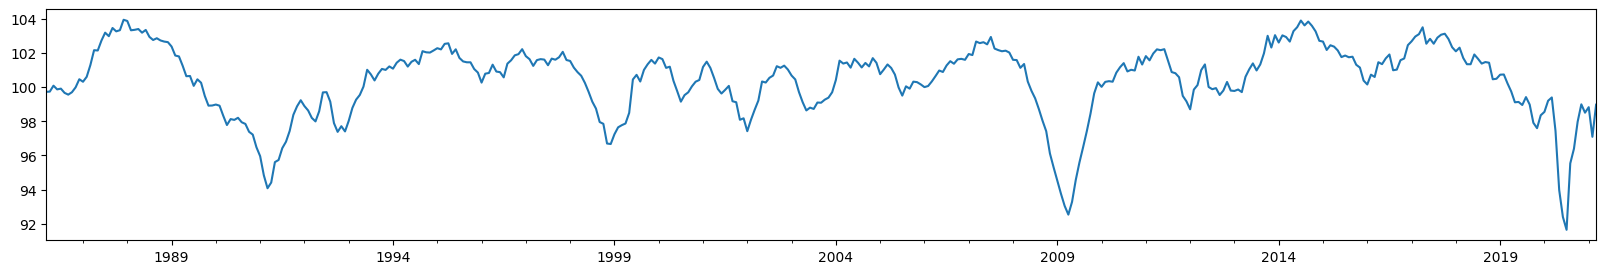

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Create an array of monthly dates
dates = pd.date_range(start='1986-03-01', end='2021-3-01', freq='MS')

df = pd.DataFrame(data=newCLI, index=pd.to_datetime(dates), columns=['Values'])

# plot the DataFrame using pandas plot method
df.plot(figsize=(20,3), legend=False)
plt.show()


We can also make a comparison with the original data

In [10]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/CLI_raw.csv'#original CLI data 
CLI = pd.read_csv(url, header=None, encoding='utf-8', skiprows=1)

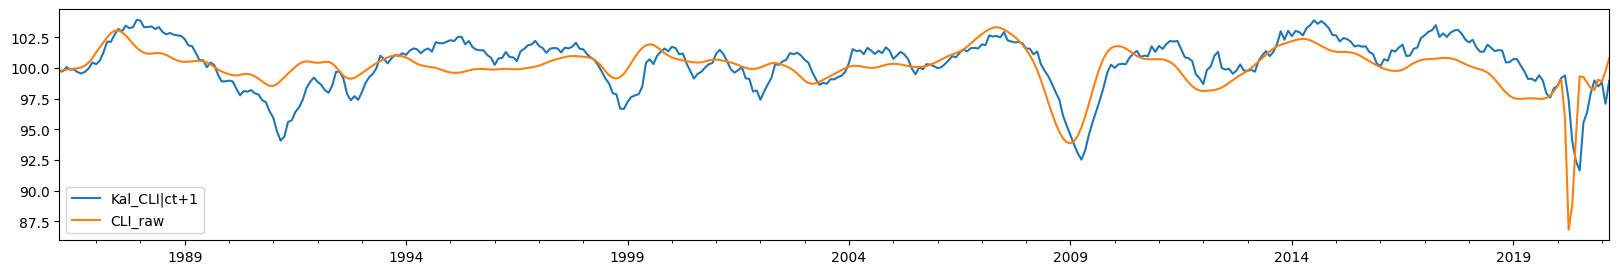

In [14]:
# Create an array of monthly dates
dates = pd.date_range(start='1986-03-01', end='2021-3-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI.ravel(), index=dates)

# Plot the series
series1.plot(figsize=(20,3), legend=False,label='Kal_CLI|ct+1')

# Create another pandas Series with the same dates as index
series2 = pd.Series(CLI.values.ravel(), index=dates)

# Plot the second series
series2.plot(figsize=(20,3), legend=False,label='CLI_raw')

# Create another pandas Series with the same dates as index. This is C_t without delta c_{t+1} in the information set. 
# Remove the '#' of bewlow two line if want to see the comparison result with Kal_Ct|ct
#series3 = pd.Series(cc.ravel(), index=dates)
#series3.plot(figsize=(20,3), legend=False,label='Kal_CLI|ct')

plt.legend()
plt.show()



save the data of $C_t$ (generated data is already in the Github) and we would come to Hamilton (1989) basic filter to calculate regimes in Rstudio. The implementation of Hamilton (1989) basic filter relies on a package in R so currecntly we are unable to provide the code of Hamilton (1989) basic filter in python but detailed instruction would also be provided in the Github folder.